In [19]:
# Cell 1: 配置（修改这里切换模型，图片保存到 eval_results/visualize/scheme_xxx/，换 scheme 不覆盖）
CONFIG_PATH = "../configs/scheme_f.yaml"
CHECKPOINT_PATH = "../checkpoints/scheme_f/best_model.pt"
N_SAMPLES = 6


In [20]:
# Cell 0: 分析全部98个样本并保存结果到CSV
%matplotlib inline
import os, json
import numpy as np
import pandas as pd
import cv2
from scipy import signal as scipy_signal
import matplotlib.pyplot as plt

# 找到项目根目录
_cwd = os.getcwd()
if os.path.exists(os.path.join(_cwd, "training_data/samples")):
    ROOT = _cwd
elif os.path.exists(os.path.join(_cwd, "../training_data/samples")):
    ROOT = os.path.dirname(_cwd)
else:
    ROOT = _cwd
os.chdir(ROOT)
print(f"Project root: {ROOT}")

def get_video_info(video_path):
    cap = cv2.VideoCapture(video_path)
    info = {"frame_count": int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), "fps": cap.get(cv2.CAP_PROP_FPS)}
    info["file_size_mb"] = os.path.getsize(video_path) / (1024 * 1024)
    info["duration_s"] = info["frame_count"] / info["fps"] if info["fps"] > 0 else 0
    info["bitrate_kbps"] = (info["file_size_mb"] * 8 * 1024) / info["duration_s"] if info["duration_s"] > 0 else 0
    cap.release()
    return info

def extract_rgb_signal(video_path, max_frames, skip_start=30):
    cap = cv2.VideoCapture(video_path)
    for _ in range(skip_start): cap.read()
    rgb = []
    for _ in range(max_frames):
        ret, frame = cap.read()
        if not ret: break
        rgb.append([frame[:,:,2].mean(), frame[:,:,1].mean(), frame[:,:,0].mean()])
    cap.release()
    return np.array(rgb)

def bandpass_filter(sig, fs):
    b, a = scipy_signal.butter(3, [0.5/(0.5*fs), 4.0/(0.5*fs)], btype='band')
    return scipy_signal.filtfilt(b, a, sig)

def get_hr(sig, fs):
    sig = sig - sig.mean()
    freqs = np.fft.rfftfreq(len(sig), 1/fs)
    fft_mag = np.abs(np.fft.rfft(sig))
    mask = (freqs >= 50/60) & (freqs <= 180/60)
    if not mask.any(): return None, 0, False
    hr_freqs, hr_mags = freqs[mask], fft_mag[mask]
    idx = np.argmax(hr_mags)
    prominence = hr_mags[idx] / (np.median(hr_mags) + 1e-8)
    return hr_freqs[idx]*60, hr_mags[idx]**2/(hr_mags**2).sum(), prominence > 2.0

# 分析全部样本
samples_dir = "training_data/samples"
pairs = sorted([d for d in os.listdir(samples_dir) if d.startswith("pair_")])
print(f"分析全部 {len(pairs)} 个样本...")

results = []
for idx, pair in enumerate(pairs):
    pair_dir = os.path.join(samples_dir, pair)
    video_path, meta_path = os.path.join(pair_dir, "video_0.mp4"), os.path.join(pair_dir, "metadata.json")
    if not os.path.exists(video_path): continue
    
    vinfo = get_video_info(video_path)
    fps = vinfo['fps']
    rgb = extract_rgb_signal(video_path, int(10*fps), int(1*fps))
    
    red_std, red_range = rgb[:,0].std(), rgb[:,0].max()-rgb[:,0].min()
    red_filt = bandpass_filter((rgb[:,0]-rgb[:,0].mean())/(red_std+1e-8), fps)
    ppg_hr, snr, is_valid = get_hr(red_filt, fps)
    
    with open(meta_path) as f: meta = json.load(f)
    gt_hr, user = meta.get("heart_rate"), meta.get("phone_user", "unknown")
    
    hr_error = abs(ppg_hr - gt_hr) if is_valid and ppg_hr else None
    quality = "good" if hr_error and hr_error<10 else ("moderate" if hr_error and hr_error<20 else ("poor" if hr_error else "no_signal"))
    
    results.append({'pair': pair, 'user': user, 'bitrate_kbps': round(vinfo['bitrate_kbps'],1),
                    'red_std': round(red_std,2), 'red_range': round(red_range,1),
                    'ppg_hr': round(ppg_hr,1) if ppg_hr else None, 'gt_hr': gt_hr,
                    'hr_error': round(hr_error,1) if hr_error else None,
                    'snr': round(snr,3), 'is_valid': is_valid, 'quality': quality})
    if (idx+1) % 20 == 0: print(f"  已处理 {idx+1}/{len(pairs)}...")

# 保存CSV
df = pd.DataFrame(results)
os.makedirs("eval_results", exist_ok=True)
df.to_csv("eval_results/ppg_analysis_all_samples.csv", index=False)
print(f"\n✓ 结果已保存到: eval_results/ppg_analysis_all_samples.csv")

# 汇总统计
print("\n" + "="*70)
print("汇总统计")
print("="*70)
print(f"总样本数: {len(results)}")
valid = df[df['is_valid']==True]
print(f"有效PPG样本: {len(valid)} ({100*len(valid)/len(results):.1f}%)")
print(f"\n按质量分类:")
for q in ['good','moderate','poor','no_signal']:
    c = len(df[df['quality']==q])
    print(f"  {q}: {c} ({100*c/len(results):.1f}%)")
if len(valid)>0:
    print(f"\n有效样本心率误差: 平均={valid['hr_error'].mean():.1f} BPM, 中位={valid['hr_error'].median():.1f} BPM")
print(f"\n信号强度: 红色通道std平均={df['red_std'].mean():.2f}, 码率平均={df['bitrate_kbps'].mean():.0f} kbps")
print(f"\n按用户分组:")
print(df.groupby('user').agg({'is_valid':'mean','hr_error':'mean','pair':'count'}).rename(columns={'is_valid':'valid_ratio','hr_error':'avg_error','pair':'count'}).round(2).to_string())

Project root: /home/xinchen/ECG
分析全部 98 个样本...
  已处理 20/98...
  已处理 40/98...
  已处理 60/98...
  已处理 80/98...

✓ 结果已保存到: eval_results/ppg_analysis_all_samples.csv

汇总统计
总样本数: 98
有效PPG样本: 98 (100.0%)

按质量分类:
  good: 80 (81.6%)
  moderate: 8 (8.2%)
  poor: 10 (10.2%)
  no_signal: 0 (0.0%)

有效样本心率误差: 平均=9.0 BPM, 中位=4.0 BPM

信号强度: 红色通道std平均=2.44, 码率平均=280 kbps

按用户分组:
      valid_ratio  avg_error  count
user                               
czq           1.0      18.23     13
fcy           1.0      10.93     15
fhy           1.0       1.75      4
fzq           1.0       7.33     24
lrk           1.0       4.80      5
nxs           1.0       1.83      6
syw           1.0       6.27     11
wcp           1.0       3.86      7
wjy           1.0      12.69     13


In [21]:
# Cell 2: 导入和初始化
%matplotlib inline
import os
import numpy as np
import pandas as pd
import torch
import yaml
import matplotlib.pyplot as plt

from dataset import create_datasets
from video_ecg_model import build_model

# 不依赖 cwd：在多个可能的工作目录下查找 config 文件，确定项目根目录
_cwd = os.getcwd()
_config_name = os.path.basename(CONFIG_PATH)  # e.g. scheme_a.yaml
_candidates = [
    os.path.join(_cwd, CONFIG_PATH),
    os.path.join(_cwd, "models", CONFIG_PATH),
    os.path.join(_cwd, "ECG", "configs", _config_name),
    os.path.join(_cwd, "configs", _config_name),
]
CONFIG_PATH_ABS = None
for p in _candidates:
    p = os.path.abspath(p)
    if os.path.isfile(p):
        CONFIG_PATH_ABS = p
        break
if CONFIG_PATH_ABS is None:
    raise FileNotFoundError(f"Config not found. cwd={_cwd!r}, CONFIG_PATH={CONFIG_PATH!r}. Tried: {_candidates}")
# 项目根 = config 所在目录的上一级（configs/ 的父目录）
_ROOT = os.path.dirname(os.path.dirname(CONFIG_PATH_ABS))
os.chdir(_ROOT)
# checkpoint 相对项目根（去掉开头的 ../ 或 ./，避免 join(ROOT, "../checkpoints/...") 跑到 ROOT 上一级）
_checkpoint_rel = CHECKPOINT_PATH.lstrip("./").lstrip("/")
CHECKPOINT_PATH_ABS = os.path.normpath(os.path.join(_ROOT, _checkpoint_rel))
print(f"Project root: {_ROOT}")

# 提取 scheme 名称；图片保存到 eval_results/visualize/scheme_xxx/，换 scheme 不会覆盖
SCHEME_NAME = os.path.splitext(_config_name)[0]  # e.g. scheme_e, scheme_f
SAVE_DIR = os.path.join("eval_results", "visualize", SCHEME_NAME)
os.makedirs(SAVE_DIR, exist_ok=True)
print(f"Scheme: {SCHEME_NAME}, Save dir: {SAVE_DIR}")

# 加载配置
with open(CONFIG_PATH_ABS) as f:
    cfg = yaml.safe_load(f)

# 设备
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# 加载模型
model = build_model(cfg).to(device)
ckpt = torch.load(CHECKPOINT_PATH_ABS, map_location=device)
# 兼容两种格式：纯 state_dict 或 {'model_state_dict': state_dict}
state_dict = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt
model.load_state_dict(state_dict)
model.eval()
print(f"Loaded: {CHECKPOINT_PATH_ABS}")

# 数据
use_imu = cfg.get("data", {}).get("use_imu", False)
_, _, test_ds = create_datasets(cfg)
test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=cfg["train"]["batch_size"],
    shuffle=False,
    num_workers=cfg.get("data", {}).get("num_workers", 0),
)
print(f"Use IMU: {use_imu}")

Project root: /home/xinchen/ECG
Scheme: scheme_f, Save dir: eval_results/visualize/scheme_f
Device: cuda
Loaded: /home/xinchen/ECG/checkpoints/scheme_f/best_model.pt
Loaded 98 sample pairs
Split: train=83 pairs, val=6, test=9
Total windows: 1042
Windows: train=882, val=66, test=94
Use IMU: False


In [22]:
# Cell 3: 获取预测结果
@torch.no_grad()
def get_predictions(model, dataloader, device, use_imu, max_samples=10):
    preds, targets = [], []
    for batch in dataloader:
        if use_imu:
            video, imu, ecg = batch
            pred = model(video.to(device), imu.to(device)).cpu().numpy()
        else:
            video, ecg = batch
            pred = model(video.to(device)).cpu().numpy()
        preds.append(pred)
        targets.append(ecg.numpy())
        if sum(len(p) for p in preds) >= max_samples:
            break
    return np.concatenate(preds)[:max_samples], np.concatenate(targets)[:max_samples]

preds, targets = get_predictions(model, test_loader, device, use_imu, N_SAMPLES)
print(f"Shape: preds={preds.shape}, targets={targets.shape}")


Shape: preds=(6, 2500), targets=(6, 2500)


Saved: /home/xinchen/ECG/eval_results/visualize/scheme_f/pred_vs_real_ecg.png


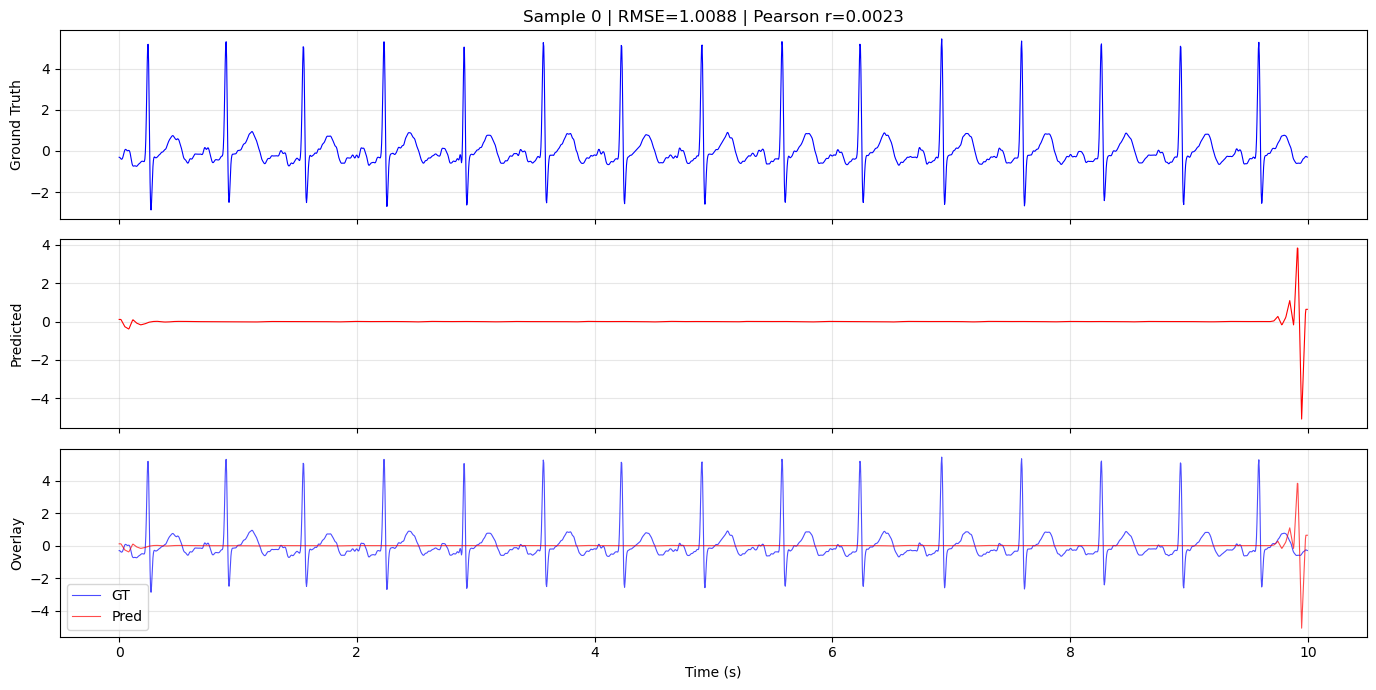

In [23]:
# Cell 4: 单样本对比（修改 idx 查看不同样本）
idx = 0  # <-- 改这里切换样本
fs = 250
t = np.arange(preds.shape[1]) / fs

pred, target = preds[idx], targets[idx]
r = np.corrcoef(pred, target)[0, 1]
rmse = np.sqrt(np.mean((pred - target) ** 2))

fig, axes = plt.subplots(3, 1, figsize=(14, 7), sharex=True)
axes[0].plot(t, target, 'b', lw=0.8)
axes[0].set_ylabel('Ground Truth')
axes[0].set_title(f'Sample {idx} | RMSE={rmse:.4f} | Pearson r={r:.4f}')

axes[1].plot(t, pred, 'r', lw=0.8)
axes[1].set_ylabel('Predicted')

axes[2].plot(t, target, 'b', lw=0.8, alpha=0.7, label='GT')
axes[2].plot(t, pred, 'r', lw=0.8, alpha=0.7, label='Pred')
axes[2].set_ylabel('Overlay')
axes[2].set_xlabel('Time (s)')
axes[2].legend()

for ax in axes:
    ax.grid(True, alpha=0.3)
plt.tight_layout()
# 一段 预测 vs 真实 ECG 对比图，保存到 eval_results/visualize/scheme_xxx/
_save = os.path.join(SAVE_DIR, "pred_vs_real_ecg.png")
plt.savefig(_save, dpi=120, bbox_inches="tight")
print("Saved:", os.path.abspath(_save))
plt.show()

Saved: /home/xinchen/ECG/eval_results/visualize/scheme_f/sample_zoom.png


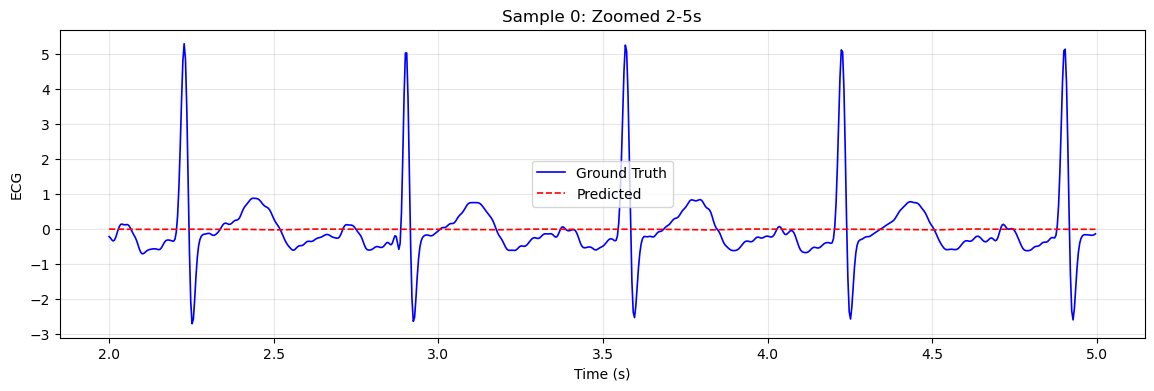

In [24]:
# Cell 5: 放大查看细节（修改 start_sec 查看不同时间段）
start_sec = 2  # <-- 改这里
duration = 3

start, end = int(start_sec * fs), int((start_sec + duration) * fs)
t_zoom = t[start:end]

plt.figure(figsize=(14, 4))
plt.plot(t_zoom, target[start:end], 'b', lw=1.2, label='Ground Truth')
plt.plot(t_zoom, pred[start:end], 'r--', lw=1.2, label='Predicted')
plt.xlabel('Time (s)')
plt.ylabel('ECG')
plt.title(f'Sample {idx}: Zoomed {start_sec}-{start_sec+duration}s')
plt.legend()
plt.grid(True, alpha=0.3)
_save = f"{SAVE_DIR}/sample_zoom.png"
plt.savefig(_save, dpi=120, bbox_inches="tight")
print("Saved:", os.path.abspath(_save))
plt.show()

Saved: /home/xinchen/ECG/eval_results/visualize/scheme_f/all_samples.png


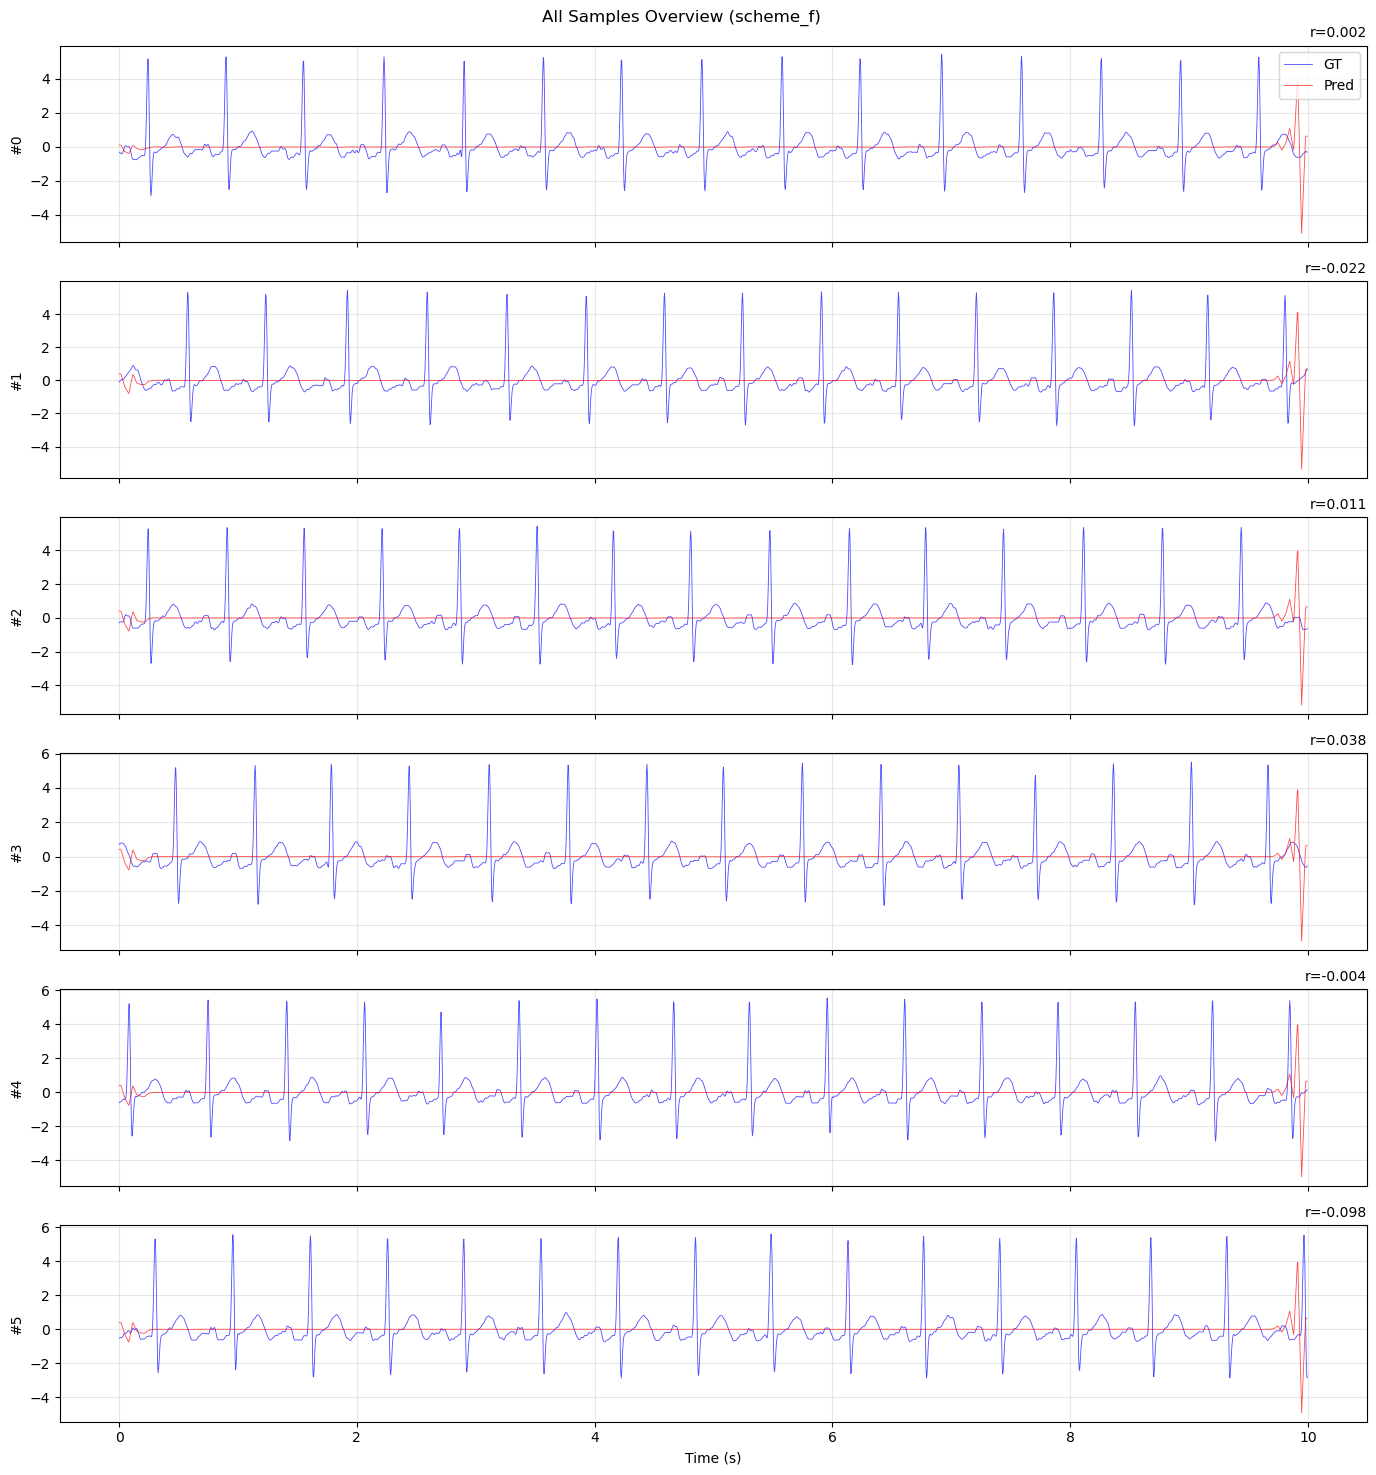

In [25]:
# Cell 6: 所有样本概览
fig, axes = plt.subplots(N_SAMPLES, 1, figsize=(14, 2.5 * N_SAMPLES), sharex=True)
for i in range(N_SAMPLES):
    r = np.corrcoef(preds[i], targets[i])[0, 1]
    axes[i].plot(t, targets[i], 'b', lw=0.6, alpha=0.7, label='GT')
    axes[i].plot(t, preds[i], 'r', lw=0.6, alpha=0.7, label='Pred')
    axes[i].set_ylabel(f'#{i}')
    axes[i].set_title(f'r={r:.3f}', loc='right', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    if i == 0:
        axes[i].legend(loc='upper right')
axes[-1].set_xlabel('Time (s)')
plt.suptitle(f'All Samples Overview ({SCHEME_NAME})')
plt.tight_layout()
_save = f"{SAVE_DIR}/all_samples.png"
plt.savefig(_save, dpi=120, bbox_inches="tight")
print("Saved:", os.path.abspath(_save))
plt.show()

In [26]:
# Cell 7: 汇总指标
print("Per-sample metrics:")
print("-" * 40)
for i in range(N_SAMPLES):
    r = np.corrcoef(preds[i], targets[i])[0, 1]
    rmse = np.sqrt(np.mean((preds[i] - targets[i]) ** 2))
    mae = np.mean(np.abs(preds[i] - targets[i]))
    print(f"Sample {i}: RMSE={rmse:.4f}, MAE={mae:.4f}, r={r:.4f}")

print("-" * 40)
print(f"Mean RMSE: {np.mean([np.sqrt(np.mean((preds[i]-targets[i])**2)) for i in range(N_SAMPLES)]):.4f}")
print(f"Mean r:    {np.mean([np.corrcoef(preds[i], targets[i])[0,1] for i in range(N_SAMPLES)]):.4f}")


Per-sample metrics:
----------------------------------------
Sample 0: RMSE=1.0088, MAE=0.5779, r=0.0023
Sample 1: RMSE=1.0288, MAE=0.5927, r=-0.0222
Sample 2: RMSE=1.0222, MAE=0.5958, r=0.0109
Sample 3: RMSE=1.0172, MAE=0.5911, r=0.0375
Sample 4: RMSE=1.0578, MAE=0.6080, r=-0.0040
Sample 5: RMSE=1.0943, MAE=0.6139, r=-0.0978
----------------------------------------
Mean RMSE: 1.0382
Mean r:    -0.0122


视频PPG信号与ECG心率关系分析

pair_0000: 3.8MB, 262kbps, 320x568
  PPG心率: 42.0 BPM, 标注: 92 BPM, 误差: 50.0 ✗
  信号SNR: 0.150, RGB std: R=12.51, G=17.68, B=3.91

pair_0001: 4.6MB, 312kbps, 320x568
  PPG心率: 42.0 BPM, 标注: 135 BPM, 误差: 93.0 ✗
  信号SNR: 0.153, RGB std: R=13.93, G=20.13, B=8.65

pair_0002: 4.1MB, 283kbps, 320x568
  PPG心率: 42.0 BPM, 标注: 138 BPM, 误差: 96.0 ✗
  信号SNR: 0.123, RGB std: R=12.69, G=6.98, B=5.86

pair_0003: 3.2MB, 221kbps, 320x568
  PPG心率: 42.0 BPM, 标注: 96 BPM, 误差: 54.0 ✗
  信号SNR: 0.132, RGB std: R=15.10, G=20.40, B=8.64

pair_0004: 3.6MB, 247kbps, 320x568
  PPG心率: 42.0 BPM, 标注: 90 BPM, 误差: 48.0 ✗
  信号SNR: 0.196, RGB std: R=13.06, G=17.18, B=12.38

图片已保存: eval_results/visualize/scheme_f/ppg_ecg_analysis.png


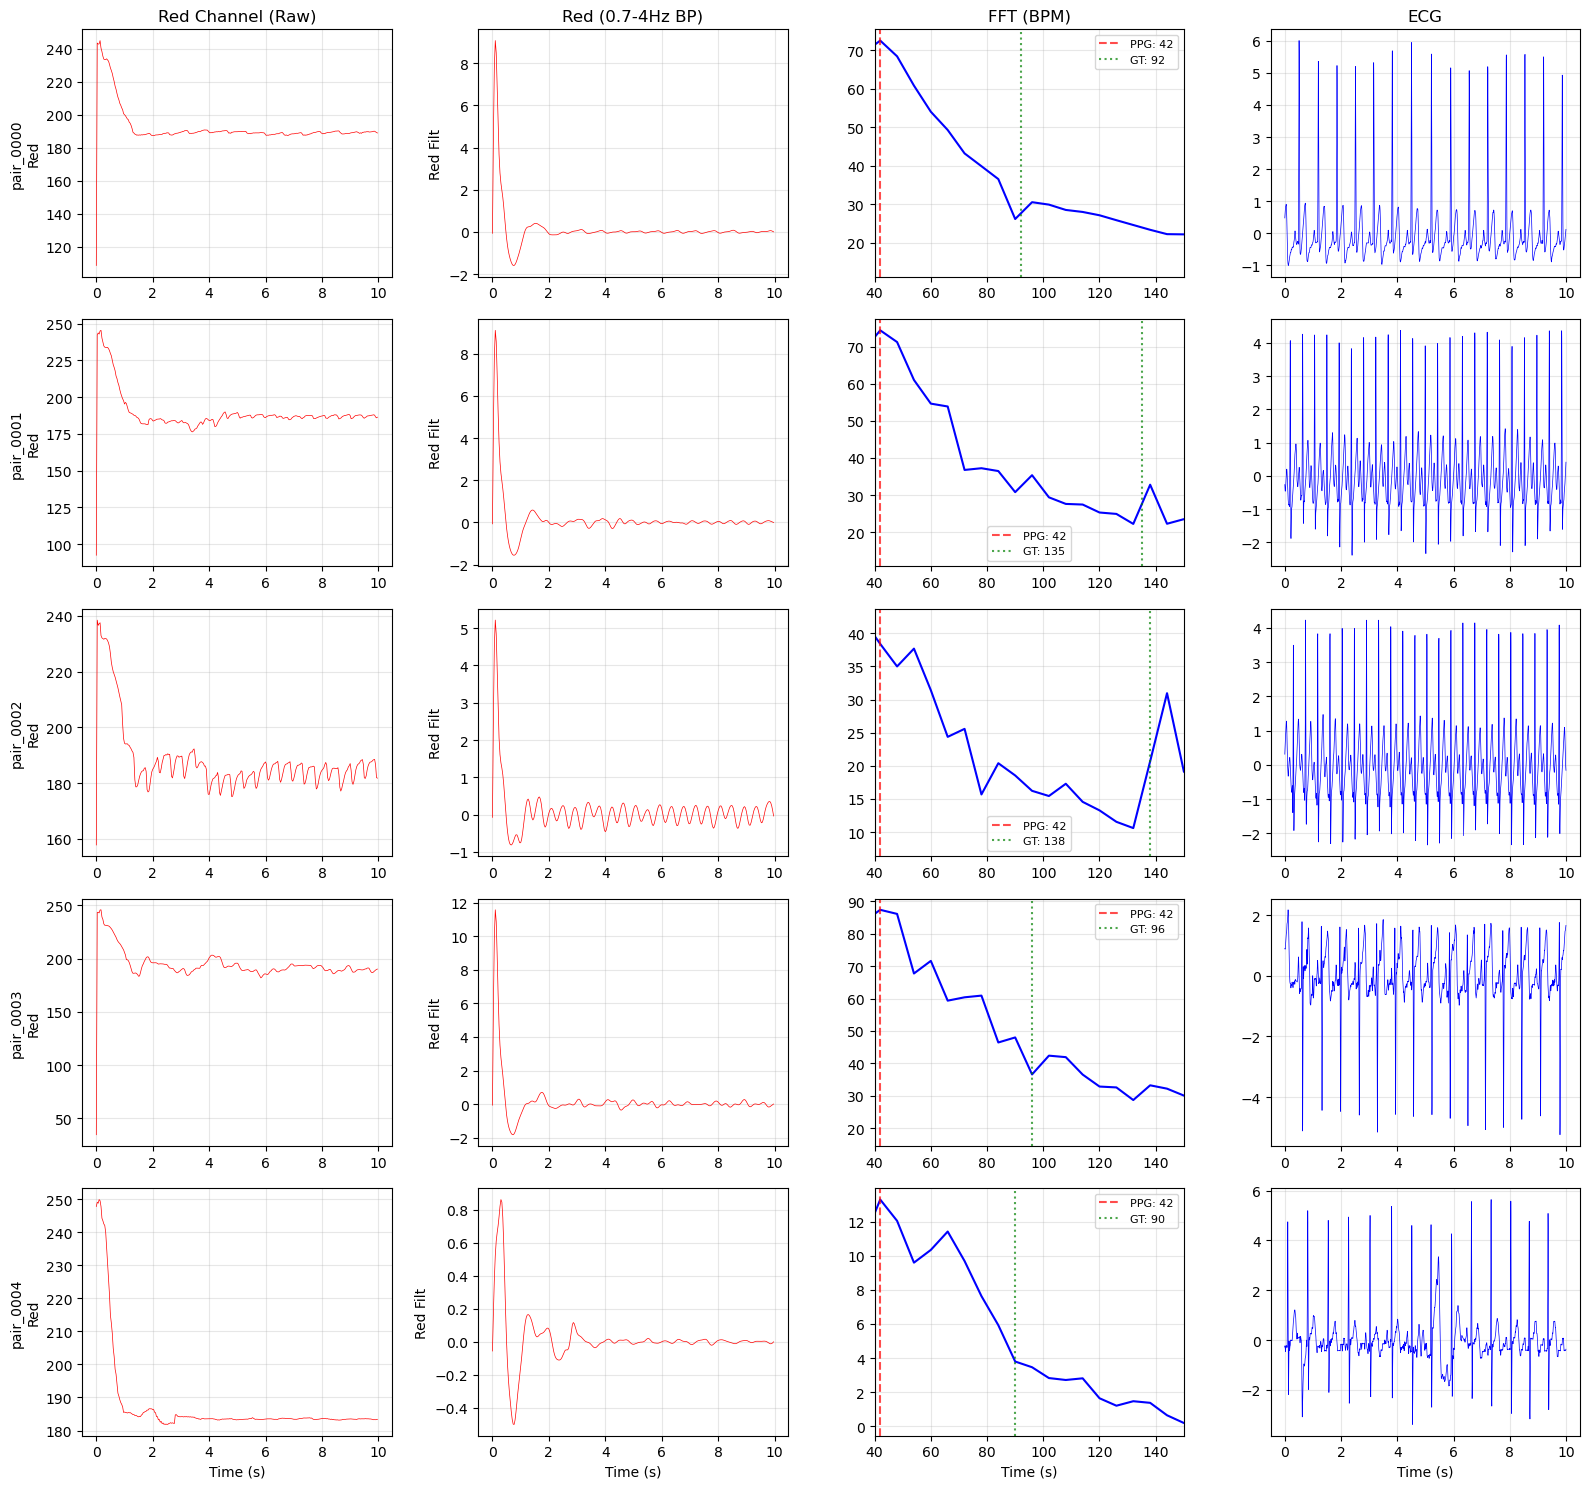


汇总
有效PPG心率检测: 5/5
PPG-ECG心率误差: 平均=68.2 BPM
平均码率: 265 kbps
平均SNR: 0.151


In [27]:
# Cell 8: 分析视频RGB信号与ECG心率的关系
# 检查视频压缩是否导致PPG信息丢失

import cv2
from scipy import signal as scipy_signal
from scipy.stats import pearsonr
import json

def get_video_info(video_path):
    """获取视频信息"""
    cap = cv2.VideoCapture(video_path)
    info = {
        "frame_count": int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
        "fps": cap.get(cv2.CAP_PROP_FPS),
        "width": int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        "height": int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
    }
    info["file_size_mb"] = os.path.getsize(video_path) / (1024 * 1024)
    info["duration_s"] = info["frame_count"] / info["fps"] if info["fps"] > 0 else 0
    info["bitrate_kbps"] = (info["file_size_mb"] * 8 * 1024) / info["duration_s"] if info["duration_s"] > 0 else 0
    cap.release()
    return info

def extract_rgb_signal(video_path, max_frames=None):
    """从视频提取RGB通道均值"""
    cap = cv2.VideoCapture(video_path)
    if max_frames is None:
        max_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    rgb_signals = []
    for _ in range(max_frames):
        ret, frame = cap.read()
        if not ret:
            break
        # BGR -> RGB
        rgb_signals.append([frame[:,:,2].mean(), frame[:,:,1].mean(), frame[:,:,0].mean()])
    cap.release()
    return np.array(rgb_signals)

def bandpass_filter(sig, fs, lowcut=0.7, highcut=4.0, order=3):
    """带通滤波 (0.7-4Hz = 42-240 BPM)"""
    nyq = 0.5 * fs
    b, a = scipy_signal.butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return scipy_signal.filtfilt(b, a, sig)

def analyze_periodicity(sig, fs):
    """FFT分析心率"""
    sig = sig - sig.mean()
    freqs = np.fft.rfftfreq(len(sig), 1/fs)
    fft_mag = np.abs(np.fft.rfft(sig))
    
    # 心率范围 0.7-3.5 Hz = 42-210 BPM
    hr_mask = (freqs >= 0.7) & (freqs <= 3.5)
    if not hr_mask.any():
        return None, 0
    
    hr_freqs = freqs[hr_mask]
    hr_mags = fft_mag[hr_mask]
    peak_idx = np.argmax(hr_mags)
    dominant_hr = hr_freqs[peak_idx] * 60
    
    # SNR
    snr = hr_mags[peak_idx]**2 / (hr_mags**2).sum()
    return dominant_hr, snr

# 分析前5个样本
samples_dir = "training_data/samples"
pairs = sorted([d for d in os.listdir(samples_dir) if d.startswith("pair_")])[:5]

print("="*70)
print("视频PPG信号与ECG心率关系分析")
print("="*70)

fig, axes = plt.subplots(len(pairs), 4, figsize=(16, 3*len(pairs)))
results = []

for idx, pair in enumerate(pairs):
    pair_dir = os.path.join(samples_dir, pair)
    video_path = os.path.join(pair_dir, "video_0.mp4")
    ecg_path = os.path.join(pair_dir, "ecg.csv")
    meta_path = os.path.join(pair_dir, "metadata.json")
    
    # 视频信息
    vinfo = get_video_info(video_path)
    fps = vinfo['fps']
    
    print(f"\n{pair}: {vinfo['file_size_mb']:.1f}MB, {vinfo['bitrate_kbps']:.0f}kbps, {vinfo['width']}x{vinfo['height']}")
    
    # 提取RGB信号 (10秒)
    max_frames = min(int(10 * fps), vinfo['frame_count'])
    rgb = extract_rgb_signal(video_path, max_frames)
    t_video = np.arange(len(rgb)) / fps
    
    # 红色通道滤波
    red_norm = (rgb[:,0] - rgb[:,0].mean()) / (rgb[:,0].std() + 1e-8)
    red_filt = bandpass_filter(red_norm, fps, 0.7, 4.0)
    
    # PPG心率
    ppg_hr, snr = analyze_periodicity(red_filt, fps)
    
    # ECG
    ecg_df = pd.read_csv(ecg_path)
    ecg = ecg_df["ecg_counts_filt_monitor"].values[:2500]
    t_ecg = np.arange(len(ecg)) / 250
    
    # 标注心率
    with open(meta_path) as f:
        meta = json.load(f)
    annotated_hr = meta.get("heart_rate")
    
    if ppg_hr:
        error = abs(ppg_hr - annotated_hr)
        status = "✓" if error < 10 else ("△" if error < 20 else "✗")
        print(f"  PPG心率: {ppg_hr:.1f} BPM, 标注: {annotated_hr} BPM, 误差: {error:.1f} {status}")
    else:
        print(f"  PPG心率: 未检测到, 标注: {annotated_hr} BPM")
    print(f"  信号SNR: {snr:.3f}, RGB std: R={rgb[:,0].std():.2f}, G={rgb[:,1].std():.2f}, B={rgb[:,2].std():.2f}")
    
    results.append({'pair': pair, 'ppg_hr': ppg_hr, 'annotated_hr': annotated_hr, 'snr': snr, 'bitrate': vinfo['bitrate_kbps']})
    
    # 绘图
    ax = axes[idx] if len(pairs) > 1 else axes
    
    # 红色原始
    ax[0].plot(t_video, rgb[:,0], 'r-', lw=0.5)
    ax[0].set_ylabel(f'{pair}\nRed')
    if idx == 0: ax[0].set_title('Red Channel (Raw)')
    ax[0].grid(True, alpha=0.3)
    
    # 红色滤波
    ax[1].plot(t_video, red_filt, 'r-', lw=0.5)
    ax[1].set_ylabel('Red Filt')
    if idx == 0: ax[1].set_title('Red (0.7-4Hz BP)')
    ax[1].grid(True, alpha=0.3)
    
    # FFT
    freqs = np.fft.rfftfreq(len(red_filt), 1/fps)
    fft_mag = np.abs(np.fft.rfft(red_filt))
    hr_mask = (freqs >= 0.5) & (freqs <= 4)
    ax[2].plot(freqs[hr_mask]*60, fft_mag[hr_mask], 'b-')
    if ppg_hr: ax[2].axvline(ppg_hr, color='r', linestyle='--', alpha=0.7, label=f'PPG: {ppg_hr:.0f}')
    if annotated_hr: ax[2].axvline(annotated_hr, color='g', linestyle=':', alpha=0.7, label=f'GT: {annotated_hr}')
    ax[2].set_xlim(40, 150)
    ax[2].legend(fontsize=8)
    if idx == 0: ax[2].set_title('FFT (BPM)')
    ax[2].grid(True, alpha=0.3)
    
    # ECG
    ecg_norm = (ecg - ecg.mean()) / (ecg.std() + 1e-8)
    ax[3].plot(t_ecg, ecg_norm, 'b-', lw=0.5)
    if idx == 0: ax[3].set_title('ECG')
    ax[3].grid(True, alpha=0.3)
    
    if idx == len(pairs) - 1:
        for a in ax: a.set_xlabel('Time (s)')

plt.tight_layout()
_save = f"{SAVE_DIR}/ppg_ecg_analysis.png"
plt.savefig(_save, dpi=150, bbox_inches='tight')
print(f"\n图片已保存: {_save}")
plt.show()

# 汇总
print("\n" + "="*70)
print("汇总")
print("="*70)
valid = [r for r in results if r['ppg_hr']]
if valid:
    errors = [abs(r['ppg_hr'] - r['annotated_hr']) for r in valid]
    print(f"有效PPG心率检测: {len(valid)}/{len(results)}")
    print(f"PPG-ECG心率误差: 平均={np.mean(errors):.1f} BPM")
    print(f"平均码率: {np.mean([r['bitrate'] for r in results]):.0f} kbps")
    print(f"平均SNR: {np.mean([r['snr'] for r in results]):.3f}")